In [154]:
import pickle
import gc
import datetime
from math import floor, ceil
from time import perf_counter

import numpy as np  
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns;   sns.set_style("whitegrid")

import importlib
import CVA_Module ; importlib.reload(CVA_Module)

from numba import njit

from tqdm import tqdm
from tqdm.notebook import trange, tqdm_notebook ; tqdm_notebook.pandas()

In [155]:
save_exposure = True

### LOAD SWAP CHARACTERISTICS AND PD

In [156]:
# Load valuation of SWAPS and netting sets
with open(f'data/swap_valuation/swap_values_dict.pickle', 'rb') as f:
    swap_values_dict = pickle.load(f)

In [157]:
scenarios = pd.read_excel('data/rates/scenarios_description.xlsx', index_col=0)

In [158]:
# Marginal PD, Survival Probability, Recovery Rates, CDS Spreads
defaults = pd.read_excel('data/pd/default_probabilies.xlsx', index_col=0)

In [159]:
# df_SOFR3m_last = pd.read_excel(f'data/rates/Scenario 1/interpolated_forward_rates_5_Scenario 1.xlsx', index_col=0)
# df_SOFR3m_FallBack = pd.read_excel(f'data/rates/Scenario 1/interpolated_forward_rates_fallback_5_Scenario 1.xlsx', index_col=0)

In [160]:
# Funding Spread
fs = pd.read_excel('data/rates/funding_spread.xlsx', index_col=0)

In [161]:
swaps_set = pd.read_excel('data/swap_valuation/contracts.xlsx', index_col=0)

### CALCULATE EXPOSURE

In [162]:
def calculate_exposures(IRS_values_df):    
    PFE = np.quantile(IRS_values_df, 0.95, axis=1)
    EFV = IRS_values_df.mean(axis=1)
    
    """ Calculate EPE where EE > 0 """
    
    IRS_values_df_positive = IRS_values_df.copy()
    IRS_values_df_negative = IRS_values_df.copy()
    
    IRS_values_df_positive[IRS_values_df_positive <= 0] = 0
    _mean_EE = IRS_values_df_positive.mean(axis=1)

    IRS_values_df_negative[IRS_values_df_negative >= 0] = 0
    _mean_ENE = IRS_values_df_negative.mean(axis=1) 

    IRS_values_df = IRS_values_df.assign(EPE=_mean_EE)
    #IRS_values_df.EPE = IRS_values_df.EPE.fillna(0)
    IRS_values_df = IRS_values_df.assign(ENE=_mean_ENE)
    #IRS_values_df.ENE = IRS_values_df.ENE.fillna(0)
    
    IRS_values_df = IRS_values_df.assign(EFV=EFV)
    IRS_values_df = IRS_values_df.assign(PFE=PFE)
    
    return IRS_values_df[['EPE', 'ENE', 'EFV', 'PFE']]

In [164]:
exposure_dict_all = {}
for scen in swap_values_dict.keys():
    exposure_dict = {}
    for swap_n in swap_values_dict[scen].keys():
        exposure_dict[swap_n] = calculate_exposures(swap_values_dict[scen][swap_n])
        
    exposure_dict_all[scen] = exposure_dict

In [165]:
# Calculated Exposure
if save_exposure:
    with open(f'data/swap_valuation/exposure_dict.pickle', 'wb') as f:
        pickle.dump(exposure_dict, f)

### Set common index

In [166]:
defaults = defaults[defaults['t'] <= exposure_dict_all['Scenario 1']['SWAP_1'].index[-1]]
defaults.index = exposure_dict_all['Scenario 1']['SWAP_1'].index

fs = fs[fs['t'] <= exposure_dict_all['Scenario 1']['SWAP_1'].index[-1]]
fs.index = exposure_dict_all['Scenario 1']['SWAP_1'].index

### CALCULATE CVA

In [167]:
recoveries = {'AA_B': 0.4,
           'BBB_C': 0.4}

In [168]:
# All counterpartires
AA_B_cols={'recovery': 'AA_B', 'PD': 'PD_AA_B', 'Survival': 'Survival_AA_B'}
A_B_cols={'recovery': 'A_B', 'PD': 'PD_A_B', 'Survival': 'Survival_A_B'}
B_C_cols={'recovery': 'B_C', 'PD': 'PD_B_C', 'Survival': 'Survival_B_C'}
BBB_C_cols={'recovery': 'BBB_C', 'PD': 'PD_BBB_C', 'Survival': 'Survival_BBB_C'}

In [169]:
portfolio_1_all_risk_profiles = {"AA with BBB": [AA_B_cols, BBB_C_cols],
                                 "BBB with AA": [BBB_C_cols, AA_B_cols]}

In [170]:
def xva_dynamics(exposures, defaults, recoveries, fs,
                 b_cols={'recovery': 'AA_B', 'PD': 'PD_AA_B', 'Survival': 'Survival_AA_B'}, 
                 cc_cols={'recovery': 'B_C', 'PD': 'PD_B_C', 'Survival': 'Survival_B_C'},
                step=1):
    
    
    
    
    cva_dynamics, dva_dynamics, fva_dynamics, fca_dynamics, fba_dynamics = [], [], [], [], []
    for i in range(0, exposures.shape[0], step):
        cva_dynamics.append(-(1-recoveries[cc_cols['recovery']]) * np.sum((exposures['EPE'].iloc[i:] * 
                                         defaults[cc_cols['PD']].iloc[i:] * 
                                         defaults[b_cols['Survival']].iloc[i:])))
        
#         dva_dynamics.append(-(1-recoveries[b_cols['recovery']]) * np.sum((exposures['ENE'].iloc[i:] * 
#                                  defaults[b_cols['PD']].iloc[i:] * 
#                                  defaults[cc_cols['Survival']].iloc[i:])))
        
#         fva_dynamics.append(-(1-recoveries[b_cols['recovery']]) * np.sum((exposures['EPE'].iloc[i:] * 
#                                  defaults[b_cols['PD']].iloc[i:] *
#                                  defaults[b_cols['Survival']].iloc[i:])))
        
        fca_dynamics.append(-np.sum((exposures['EPE'].iloc[i:] * fs)))
        
        fba_dynamics.append(-np.sum((exposures['ENE'].iloc[i:] * fs)))
        
        

    df = [cva_dynamics, fca_dynamics, fba_dynamics] # dva_dynamics, fva_dynamics, 
    df = pd.DataFrame(df, index= ['CVA', 'FCA', 'FBA']) # 'DVA', 'FVA', 
    
    df = df.T.merge(exposures.reset_index()[['EFV']], how='left', left_index=True, right_index=True)
    
    df['FVA'] = df['FCA'] + df['FBA']
    df['XVA'] = df['CVA'] + df['FVA']
    df['FairValue'] = df['EFV'] + df['XVA']
    
    return df

In [171]:
# 2 by number of unilateral trades
circles_num = (len(exposure_dict_all) * 
               len(exposure_dict_all['Scenario 1']) * 
               len(list(portfolio_1_all_risk_profiles.keys())))
print(f"Number of circles = {circles_num}")

xva_all_portfolios_and_scen = {}
for scen in tqdm(exposure_dict_all.keys()):
    xva_all_portfolios = {}
    for risk_profile in tqdm(list(portfolio_1_all_risk_profiles.keys())):
        xva_for_risk = {}
        for swap_n in tqdm(exposure_dict_all[scen].keys()):

            xva = xva_dynamics(exposure_dict_all[scen][swap_n], 
                               defaults,
                               recoveries,
                               fs['FS_Fwd'],
                               b_cols=portfolio_1_all_risk_profiles[risk_profile][0], 
                               cc_cols=portfolio_1_all_risk_profiles[risk_profile][1], step=1)
            xva_for_risk[swap_n] = xva 
        xva_all_portfolios[risk_profile] = xva_for_risk
    xva_all_portfolios_and_scen[scen] = xva_all_portfolios

Number of circles = 24


  0%|                                                                                        | 0/2 [00:00<?, ?it/s]

  0%|                                                                                        | 0/6 [00:00<?, ?it/s]

 17%|█████████████▎                                                                  | 1/6 [00:00<00:01,  2.67it/s]

 33%|██████████████████████████▋                                                     | 2/6 [00:00<00:01,  2.69it/s]

 50%|████████████████████████████████████████                                        | 3/6 [00:01<00:01,  2.79it/s]

 67%|█████████████████████████████████████████████████████▎                          | 4/6 [00:01<00:00,  2.78it/s]

 83%|██████████████████████████████████████████████████████████████████▋             | 5/6 [00:01<00:00,  2.67it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.72it/s]

 50%|████████████████████████████████████████                   

### PNL

In [172]:
effective_notional_ns_2 = swaps_set.loc['notional']['SWAP_1'] - swaps_set.loc['notional']['SWAP_2']
effective_notional_ns_3 = swaps_set.loc['notional']['SWAP_1'] - swaps_set.loc['notional']['SWAP_3']

In [174]:
xva_all_portfolios_and_scen['Scenario 1']['AA with BBB']['SWAP_1']

,CVA,FCA,FBA,EFV,FVA,XVA,FairValue
0,-98.300921,-16.799411,4.757828,-2.573030,-12.041582,-110.342503,-112.915534
1,-98.300921,-16.799411,4.757828,35.418336,-12.041582,-110.342503,-74.924167
2,-98.300000,-16.794546,4.753612,103.623969,-12.040934,-110.340934,-6.716964
3,-98.295762,-16.787979,4.748715,163.880380,-12.039263,-110.335026,53.545354
4,-98.286787,-16.780772,4.743790,217.981896,-12.036983,-110.323769,107.658127
...,...,...,...,...,...,...,...
256,-0.188730,-0.007948,0.006122,47.171369,-0.001826,-0.190556,46.980813
257,-0.141579,-0.005149,0.003975,46.812769,-0.001174,-0.142753,46.670016
258,-0.094363,-0.003287,0.002544,46.031184,-0.000743,-0.095106,45.936078
259,-0.047213,-0.001627,0.001262,45.394773,-0.000365,-0.047578,45.347195


In [175]:
def calc_initials(xva_all_portfolios_and_scen, scen='Scenario 1', pair='AA with BBB'):
    initial_values = {}
    for i in xva_all_portfolios_and_scen[scen][pair].keys():
        val = []
        for adj in xva_all_portfolios_and_scen[scen][pair][i].columns:

            val.append(xva_all_portfolios_and_scen[scen][pair][i].iloc[0].loc[adj])


        initial_values[i] = val

    initial_values = pd.DataFrame.from_dict(initial_values, orient='index')
    initial_values.columns = xva_all_portfolios_and_scen[scen][pair]['SWAP_1'].columns
    return initial_values

In [176]:
initials_scen_1_aaa = calc_initials(xva_all_portfolios_and_scen, scen='Scenario 1', pair='AA with BBB')
initials_scen_2_aaa = calc_initials(xva_all_portfolios_and_scen, scen='Scenario 2', pair='AA with BBB')

In [262]:
initials_scen_1_aaa[['CVA', 'FCA', 'FBA', 'XVA']].round(4).to_excel("Initial_valuation_scen_1.xlsx")
initials_scen_2_aaa[['CVA', 'FCA', 'FBA', 'XVA']].round(4).to_excel("Initial_valuation_scen_2.xlsx")

<Axes: >

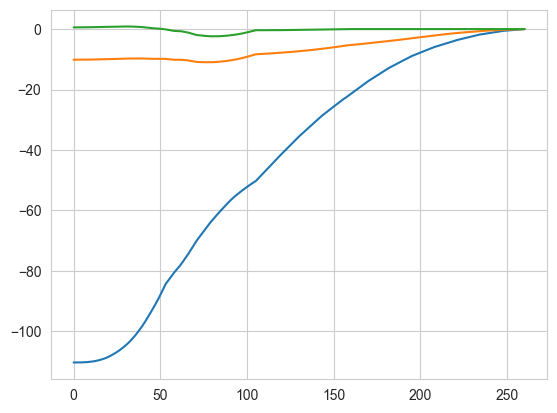

In [255]:
xva_all_portfolios_and_scen['Scenario 1']['AA with BBB']['SWAP_1']['XVA'].plot()

xva_all_portfolios_and_scen['Scenario 1']['AA with BBB']['SWAP_2']['XVA'].plot()

xva_all_portfolios_and_scen['Scenario 1']['AA with BBB']['SWAP_3']['XVA'].plot()

<Axes: >

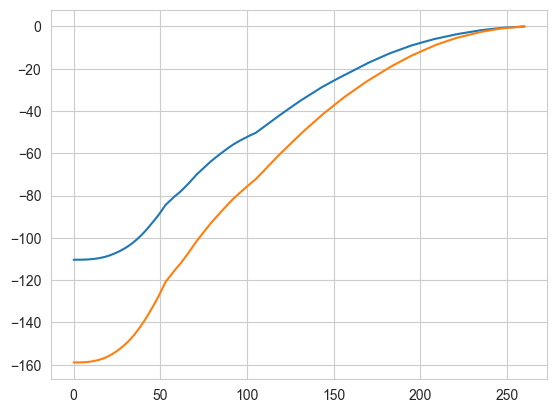

In [257]:
xva_all_portfolios_and_scen['Scenario 1']['AA with BBB']['SWAP_1']['XVA'].plot()
xva_all_portfolios_and_scen['Scenario 2']['AA with BBB']['SWAP_1']['XVA'].plot()

In [241]:
initials_scen_1_aaa

,CVA,FCA,FBA,EFV,FVA,XVA,FairValue
SWAP_1,-98.300921,-16.799411,4.757828,-2.573030,-12.041582,-110.342503,-112.915534
SWAP_2,-16.158556,-2.378914,8.399705,1.286515,6.020791,-10.137765,-8.851250
SWAP_3,-5.944175,-1.253099,7.767178,1.041429,6.514079,0.569904,1.611333
NS_1,-98.300921,-16.799411,4.757828,-2.573030,-12.041582,-110.342503,-112.915534
NS_2,-49.150460,-8.399705,2.378914,-1.286515,-6.020791,-55.171252,-56.457767
NS_3,-81.913709,-13.453023,7.925519,-1.531601,-5.527504,-87.441213,-88.972814


In [242]:
initials_scen_2_aaa

,CVA,FCA,FBA,EFV,FVA,XVA,FairValue
SWAP_1,-148.088317,-25.433555,14.592556,-2.573031,-10.840999,-158.929316,-161.502346
SWAP_2,-48.849906,-7.296278,12.716777,1.286515,5.420499,-43.429406,-42.142891
SWAP_3,-23.333035,-4.854067,10.915425,1.041429,6.061358,-17.271677,-16.230247
NS_1,-148.088317,-25.433555,14.592556,-2.573031,-10.840999,-158.929316,-161.502346
NS_2,-74.044159,-12.716777,7.296278,-1.286515,-5.420499,-79.464658,-80.751173
NS_3,-140.275145,-23.841741,19.062101,-1.531601,-4.779640,-145.054785,-146.586387


## Change of in Initial Derivative value given 1 pct change in implied volatility

In [191]:
(initials_scen_2_aaa.iloc[:3] / initials_scen_1_aaa.iloc[:3]) - 1

,CVA,FCA,FBA,EFV,FVA,XVA,FairValue
SWAP_1,0.506479,0.513955,2.067062,7.002567e-08,-0.099703,0.440327,0.430293
SWAP_2,2.023160,2.067062,0.513955,7.002567e-08,-0.099703,3.283923,3.761236
SWAP_3,2.925361,2.873649,0.405327,6.807308e-08,-0.069499,-31.306297,-11.072559


### Change as a Percent of notional amount

In [246]:
(initials_scen_2_aaa.iloc[:3] - initials_scen_1_aaa.iloc[:3]) / 100000 * 100

,CVA,FCA,FBA,EFV,FVA,XVA,FairValue
SWAP_1,-0.049787,-0.008634,0.009835,-1.801782e-10,0.001201,-0.048587,-0.048587
SWAP_2,-0.032691,-0.004917,0.004317,9.008909e-11,-0.000600,-0.033292,-0.033292
SWAP_3,-0.017389,-0.003601,0.003148,7.089329e-11,-0.000453,-0.017842,-0.017842


## Initial Value Tables/Graphs

''

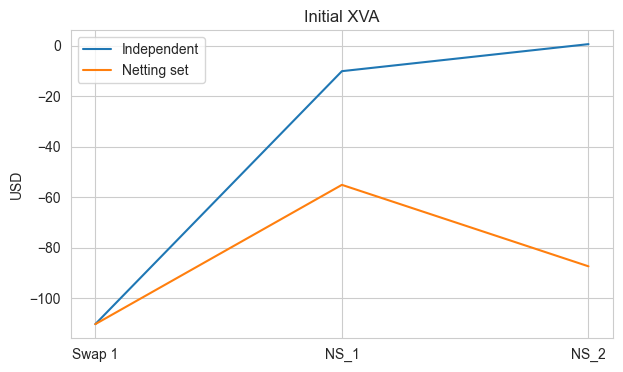

In [263]:
fig, axs = plt.subplots(1, figsize=(7,4))
axs.plot(['Swap 1', 'NS_1', 'NS_2'], initials_scen_1_aaa['XVA'].loc[['SWAP_1', 'SWAP_2', 'SWAP_3']].values, label='Independent')
axs.plot(initials_scen_1_aaa['XVA'].loc[['NS_1', 'NS_2', 'NS_3']].values, label='Netting set')

# axs.plot(initials_scen_1['XVA'].loc[['SWAP_1', 'SWAP_2', 'SWAP_3']].values, label='XVA - Independent')
# axs.plot(initials_scen_1['XVA'].loc[['NS_1', 'NS_2', 'NS_3']].values, label='XVA - Netting set')

plt.ylabel("USD")
plt.title("Initial XVA")

plt.legend()
;

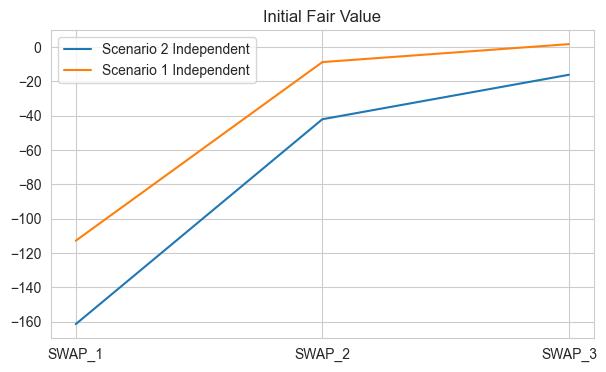

In [252]:
fig, axs = plt.subplots(1, figsize=(7,4))
axs.plot(initials_scen_2_aaa['FairValue'].loc[['SWAP_1', 'SWAP_2', 'SWAP_3']].index.values, initials_scen_2_aaa['FairValue'].loc[['SWAP_1', 'SWAP_2', 'SWAP_3']].values, label='Scenario 2 Independent')
axs.plot(initials_scen_1_aaa['FairValue'].loc[['SWAP_1', 'SWAP_2', 'SWAP_3']].values, label='Scenario 1 Independent')

plt.legend()
plt.title('Initial Fair Value');

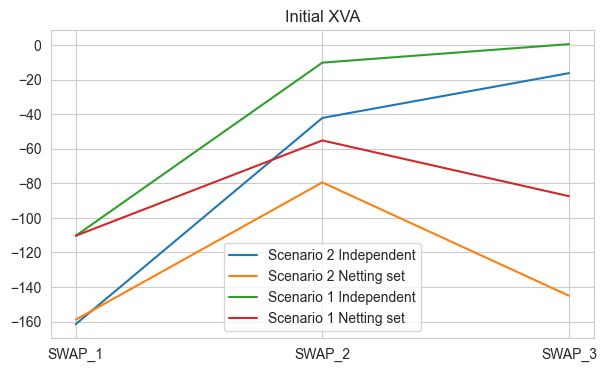

In [198]:
fig, axs = plt.subplots(1, figsize=(7,4))
axs.plot(initials_scen_2_aaa['XVA'].loc[['SWAP_1', 'SWAP_2', 'SWAP_3']].index.values, initials_scen_2_aaa['FairValue'].loc[['SWAP_1', 'SWAP_2', 'SWAP_3']].values, label='Scenario 2 Independent')
axs.plot(initials_scen_2_aaa['XVA'].loc[['NS_1', 'NS_2', 'NS_3']].values, label='Scenario 2 Netting set')
axs.plot(initials_scen_1_aaa['XVA'].loc[['SWAP_1', 'SWAP_2', 'SWAP_3']].values, label='Scenario 1 Independent')
axs.plot(initials_scen_1_aaa['XVA'].loc[['NS_1', 'NS_2', 'NS_3']].values, label='Scenario 1 Netting set')


# axs.plot(initials_scen_2['XVA'].loc[['SWAP_1', 'SWAP_2', 'SWAP_3']].values, label='XVA - Independent')
# axs.plot(initials_scen_2['XVA'].loc[['NS_1', 'NS_2', 'NS_3']].values, label='XVA - Netting set')
plt.legend()
plt.title('Initial XVA');

## Exposure

''

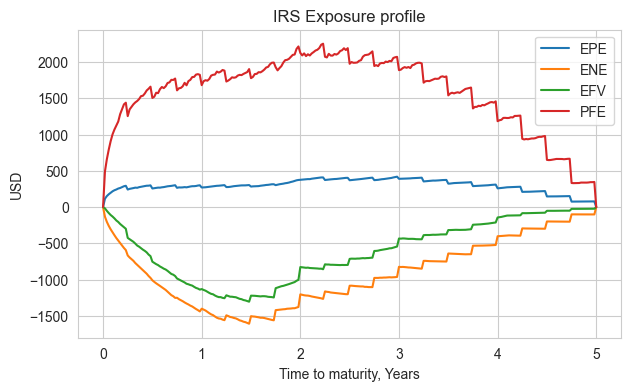

In [219]:
exposure_dict_all['Scenario 1']['SWAP_2'].plot(figsize=(7, 4)) #.keys()
plt.xlabel("Time to maturity, Years")
plt.ylabel("USD")
plt.title("IRS Exposure profile")
#plt.legend(['EPE_1', 'EPE_2', 'EFV_1', 'EFV_2'])
;

## EPE DIfferent Scenarios

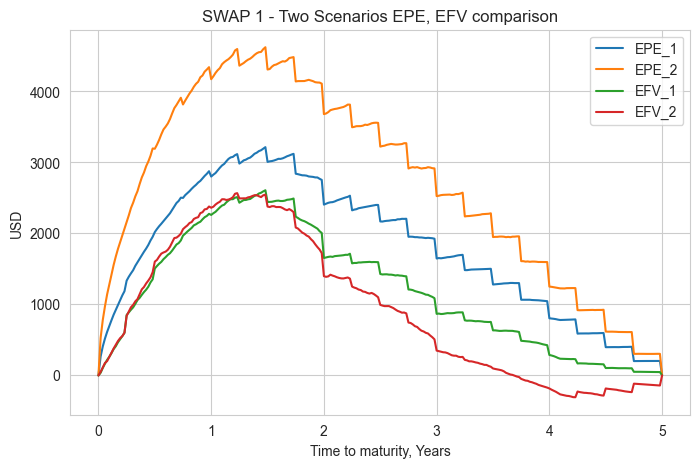

In [214]:
exposure_dict_all['Scenario 1']['SWAP_1']['EPE'].plot(figsize=(8, 5)) #.keys()
exposure_dict_all['Scenario 2']['SWAP_1']['EPE'].plot()

exposure_dict_all['Scenario 1']['SWAP_1']['EFV'].plot() #.keys()
exposure_dict_all['Scenario 2']['SWAP_1']['EFV'].plot()

plt.xlabel("Time to maturity, Years")
plt.ylabel("USD")
plt.title("SWAP 1 - Two Scenarios EPE, EFV comparison")
plt.legend(['EPE_1', 'EPE_2', 'EFV_1', 'EFV_2']);

''

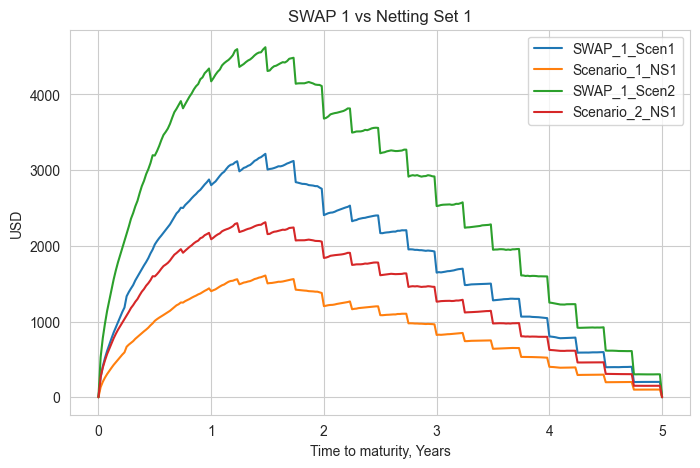

In [229]:
exposure_dict_all['Scenario 1']['NS_1']['EPE'].plot(figsize=(8, 5))
exposure_dict_all['Scenario 1']['NS_2']['EPE'].plot() #.keys()
exposure_dict_all['Scenario 2']['NS_1']['EPE'].plot()
exposure_dict_all['Scenario 2']['NS_2']['EPE'].plot()

plt.xlabel("Time to maturity, Years")
plt.ylabel("USD")
plt.title("SWAP 1 vs Netting Set 1")


plt.legend(['SWAP_1_Scen1', 'Scenario_1_NS1', 'SWAP_1_Scen2', 'Scenario_2_NS1'])

;

''

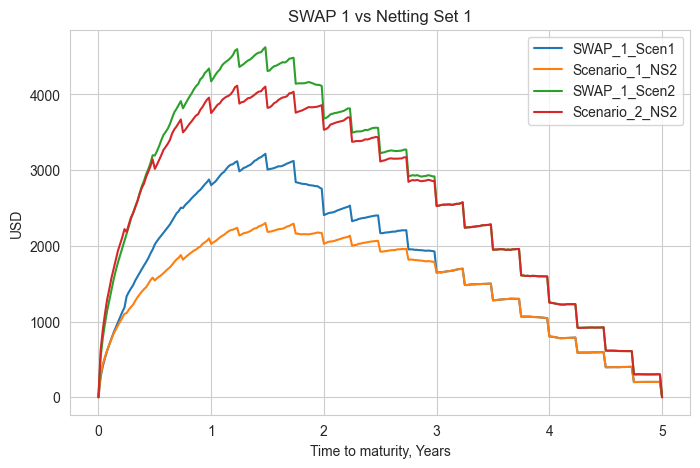

In [230]:
exposure_dict_all['Scenario 1']['NS_1']['EPE'].plot(figsize=(8, 5))
exposure_dict_all['Scenario 1']['NS_3']['EPE'].plot() #.keys()
exposure_dict_all['Scenario 2']['NS_1']['EPE'].plot()
exposure_dict_all['Scenario 2']['NS_3']['EPE'].plot()

plt.xlabel("Time to maturity, Years")
plt.ylabel("USD")
plt.title("SWAP 1 vs Netting Set 1")


plt.legend(['SWAP_1_Scen1', 'Scenario_1_NS2', 'SWAP_1_Scen2', 'Scenario_2_NS2'])

;

''

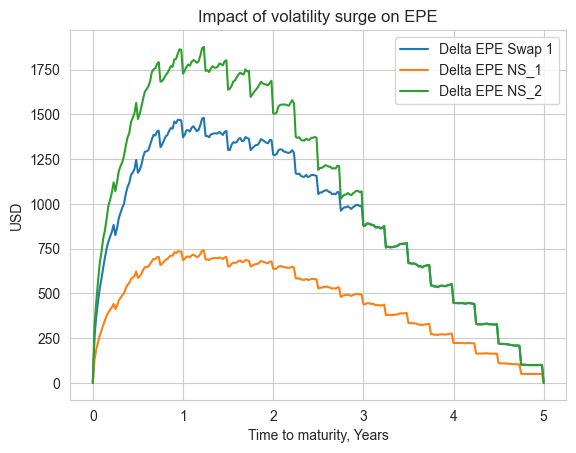

In [238]:
(exposure_dict_all['Scenario 2']['NS_1']['EPE'] - exposure_dict_all['Scenario 1']['NS_1']['EPE']).plot()
(exposure_dict_all['Scenario 2']['NS_2']['EPE'] - exposure_dict_all['Scenario 1']['NS_2']['EPE']).plot()
(exposure_dict_all['Scenario 2']['NS_3']['EPE'] - exposure_dict_all['Scenario 1']['NS_3']['EPE']).plot()


plt.title('Impact of volatility surge on EPE')
plt.xlabel("Time to maturity, Years")
plt.ylabel("USD")
plt.legend(['Delta EPE Swap 1', 'Delta EPE NS_1', 'Delta EPE NS_2'])
;

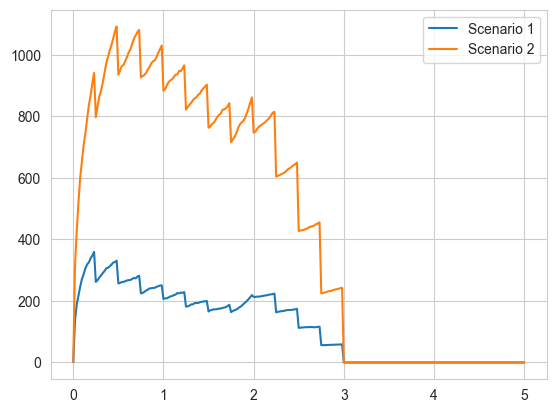

In [203]:
exposure_dict_all['Scenario 1']['SWAP_3']['EPE'].plot() #.keys()
exposure_dict_all['Scenario 2']['SWAP_3']['EPE'].plot()
plt.legend(['Scenario 1', 'Scenario 2'])

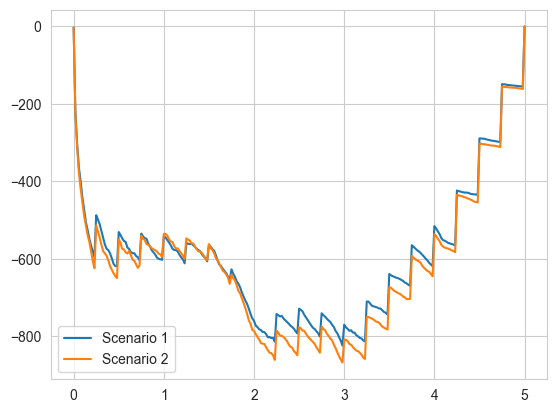

In [151]:
exposure_dict_all['Scenario 1']['SWAP_1']['ENE'].plot() #.keys()
exposure_dict_all['Scenario 2']['SWAP_1']['ENE'].plot()
plt.legend(['Scenario 1', 'Scenario 2'])

## CHARTS

In [ ]:
swap_values_chart = swap_values_dict['Scenario 1']['NS_2']
exposures_chart = exposure_dict_all['Scenario 1']['NS_2']

In [ ]:
""" step (2) : Plot the results of CVA """
fig, axs = plt.subplots(1, figsize=(20,7))
axs.plot(swap_values_chart.index.values, swap_values_chart.sample(100, axis=1).values, alpha=0.8, lw=0.5)
exposures_chart.EPE.plot(grid=True, title='Expected Positive Exposure for the duration of the Swap', xlabel='Years - Until Maturity', ylabel='% of Notional', ax=axs, color='tab:green', lw=4, legend=True) #, marker='o')
exposures_chart.ENE.plot(grid=True, title='Expected Negative Exposure for the duration of the Swap', xlabel='Years - Until Maturity', ylabel='% of Notional', ax=axs, color='tab:red', lw=4, legend=True) #, marker='o')
exposures_chart.PFE.plot(grid=True, title='Potential Future Exposure for the duration of the Swap', xlabel='Years - Until Maturity', ylabel='% of Notional', ax=axs, color='tab:blue', lw=4, legend=True) #, marker='o')
exposures_chart.EFV.plot(grid=True, title='Long Swap (Pay Fix - Receive Float) Exposures', xlabel='Years - Until Maturity', ylabel='Swap Value', ax=axs, color='tab:purple', lw=4, legend=True) #, marker='o')
gc.collect();print()
# if SAVE_CHARTS: plt.savefig('Charts/6. EPE.pdf')

In [ ]:
""" step (2) : Plot the results of CVA """
fig, axs = plt.subplots(1, figsize=(20,7))
axs.plot(swap_values_chart.index.values, swap_values_chart.sample(100, axis=1).values, alpha=0.8, lw=0.5)
exposures_chart.EPE.plot(grid=True, title='Expected Positive Exposure for the duration of the Swap', xlabel='Years - Until Maturity', ylabel='% of Notional', ax=axs, color='tab:green', lw=4, legend=True) #, marker='o')
exposures_chart.ENE.plot(grid=True, title='Expected Negative Exposure for the duration of the Swap', xlabel='Years - Until Maturity', ylabel='% of Notional', ax=axs, color='tab:red', lw=4, legend=True) #, marker='o')
exposures_chart.PFE.plot(grid=True, title='Potential Future Exposure for the duration of the Swap', xlabel='Years - Until Maturity', ylabel='% of Notional', ax=axs, color='tab:blue', lw=4, legend=True) #, marker='o')
exposures_chart.EFV.plot(grid=True, title='Long Swap (Pay Fix - Receive Float) Exposures', xlabel='Years - Until Maturity', ylabel='Swap Value', ax=axs, color='tab:purple', lw=4, legend=True) #, marker='o')
gc.collect();print()
# if SAVE_CHARTS: plt.savefig('Charts/6. EPE.pdf')